## Data Visualization

This Jupyter notebook aims to showcase the necessity and utility of plotting xarray data, demonstrating how visual representation enhances our ability to interpret trends, anomalies, and spatial distributions within datasets. Through interactive and static visualizations, we illuminate the significance of plotting as an indispensable tool for scientific exploration and decision-making in fields ranging from agriculture and environmental monitoring to climate research and beyond.

The xarray package provides built-in methods for plotting individual data variables or measurements. In addition, `matplotlib` or/and `seaborn` can be used. 

### Required Libraries

In [2]:
# Previous imports
import pyproj
import pystac_client

import numpy as np

from shapely.geometry import box
from shapely.ops import transform
import odc.stac
from odc.geo.geobox import GeoBox

# Current imports
from geogif import dgif
import matplotlib.pyplot as plt


In [3]:
def digitize_date(month,day):    
    if month<10:
        month=f"0{month}"

    if day<10:
        day=f"0{day}"

    return month,day

STAC_URL = "https://earth-search.aws.element84.com/v1"
# STAC connection information for Sentinel 2 COGs
# v0 collection
# STAC_COLLECTION = "sentinel-s2-l2a-cogs"
# v1 collection 
STAC_COLLECTION = "sentinel-2-l2a"


# spatial projection information
CRS_STRING = "9705"
EPSG = pyproj.CRS.from_string(CRS_STRING).to_epsg()

aoi = (23.906250,38.000356,24.004786,38.062149)
aoi_box = box(*aoi)

# BANDS = ["B04", "B03", "B02"]
BANDS = ["red", "green", "blue"]
START_DATE = "2022-06-01"
END_DATE = "2022-08-31"

# STAC items store bounding box info in epsg:4326
transformer_4326 = pyproj.Transformer.from_crs(
    crs_from=CRS_STRING,
    crs_to="epsg:4326",
    always_xy=True,
)
bbox_4326 = transform(transformer_4326.transform, aoi_box).bounds

catalog = pystac_client.Client.open(STAC_URL)
catalog.add_conforms_to("ITEM_SEARCH")
catalog.add_conforms_to("QUERY")

stac_items = catalog.search(
    collections=[STAC_COLLECTION],
    bbox=bbox_4326,
    datetime=[START_DATE, END_DATE],
    query={"eo:cloud_cover": {"lt": 10}}
)

# dx = 3/3600  # ~90m resolution
dx = 20 / 111320 # ~20m res
epsg = 4326
geobox = GeoBox.from_bbox(aoi, crs=f"epsg:{epsg}", resolution=dx)

# using Open Data Cube stac component
data = odc.stac.load(
    stac_items.items(),
    chunks={},
    geobox=geobox,
    bands=BANDS,
    resampling="bilinear",
    groupby="solar_day" # delete duplicates due to satellite overlap
)

In [4]:
data

<xarray.Dataset> Size: 13MB
Dimensions:      (latitude: 345, longitude: 549, time: 11)
Coordinates:
  * latitude     (latitude) float64 3kB 38.06 38.06 38.06 ... 38.0 38.0 38.0
  * longitude    (longitude) float64 4kB 23.91 23.91 23.91 ... 24.0 24.0 24.0
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 88B 2022-06-14T09:19:53.735000 ... 202...
Data variables:
    red          (time, latitude, longitude) uint16 4MB dask.array<chunksize=(1, 345, 549), meta=np.ndarray>
    green        (time, latitude, longitude) uint16 4MB dask.array<chunksize=(1, 345, 549), meta=np.ndarray>
    blue         (time, latitude, longitude) uint16 4MB dask.array<chunksize=(1, 345, 549), meta=np.ndarray>

### Plot a single timestamp

Xarray comes with the isel and sel methods in order to filter and select data based on certain parameters. 

1. `sel`: This method is used for <b>label-based indexing</b>, meaning you select data based on the labels of the axes (like the names of rows or columns).
2. `isel`: This method is used for <b>position-based indexing</b>, meaning you select data based on the integer position along an axis (like the index number of rows or columns).


As it is depicted below the xarray consists of 15 timesteps, so and index from 0 to 14 can be selected

In [4]:
data

<xarray.Dataset> Size: 13MB
Dimensions:      (latitude: 345, longitude: 549, time: 11)
Coordinates:
  * latitude     (latitude) float64 3kB 38.06 38.06 38.06 ... 38.0 38.0 38.0
  * longitude    (longitude) float64 4kB 23.91 23.91 23.91 ... 24.0 24.0 24.0
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 88B 2022-06-14T09:19:53.735000 ... 202...
Data variables:
    red          (time, latitude, longitude) uint16 4MB dask.array<chunksize=(1, 345, 549), meta=np.ndarray>
    green        (time, latitude, longitude) uint16 4MB dask.array<chunksize=(1, 345, 549), meta=np.ndarray>
    blue         (time, latitude, longitude) uint16 4MB dask.array<chunksize=(1, 345, 549), meta=np.ndarray>

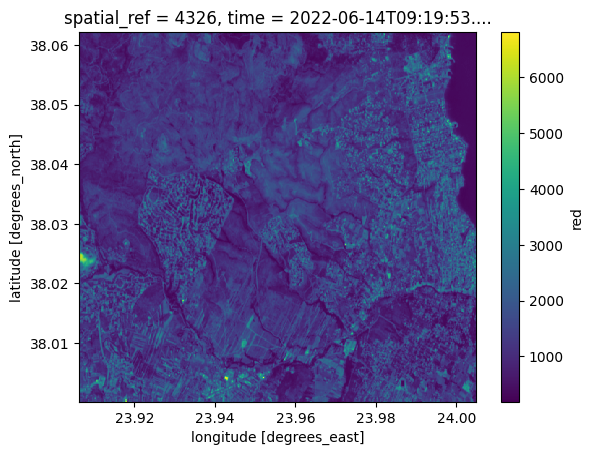

In [5]:
# first_timestep = data.B04.isel(time=0)
first_timestep = data.red.isel(time=0)
first_timestep.plot()

Alternatively, we can use the sel and select based on the actual value. The actual values can be retrieved by using the command `data.time.values`

In [6]:
data.time.values

array(['2022-06-14T09:19:53.735000000', '2022-06-19T09:20:02.032000000',
       '2022-06-29T09:20:03.258000000', '2022-07-04T09:19:55.484000000',
       '2022-07-14T09:19:54.673000000', '2022-07-19T09:20:02.140000000',
       '2022-07-24T09:19:55.414000000', '2022-07-29T09:19:59.865000000',
       '2022-08-03T09:19:54.987000000', '2022-08-18T09:20:02.990000000',
       '2022-08-28T09:20:02.889000000'], dtype='datetime64[ns]')

In [7]:
timesteps = [value for value in data.time.values]
timesteps[0]

numpy.datetime64('2022-06-14T09:19:53.735000000')

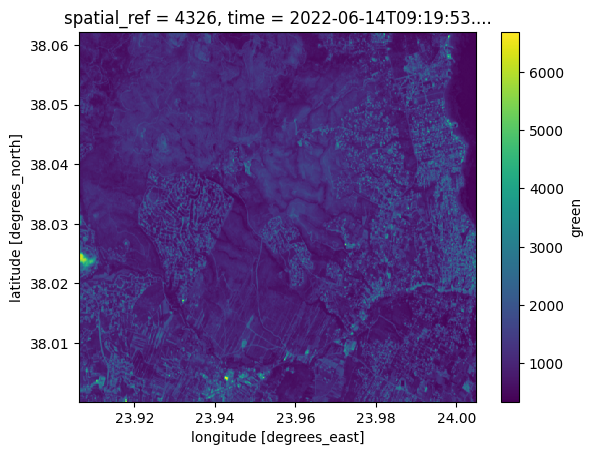

In [8]:
# data.B02.sel(time=timesteps[0]).plot()

data.green.sel(time=timesteps[0]).plot()

### Plot multiple timesteps

By not using `(i)sel`, all the timesteps are plotted.  

/home/fotis/dev/tools/miniforge3/envs/igarss_ss/lib/python3.11/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


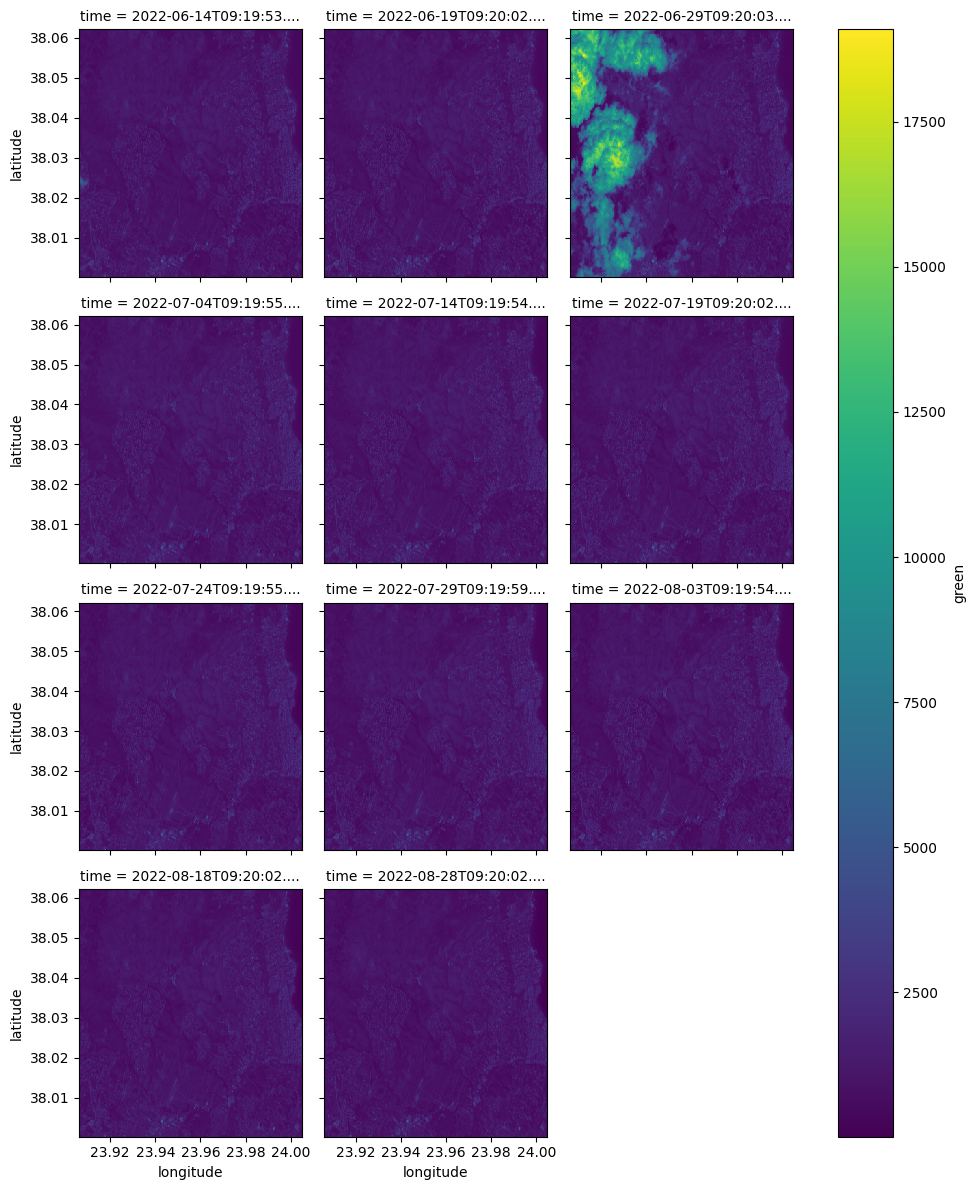

In [9]:
# data.B04.plot(col='time',col_wrap=3)
data.green.plot(col='time',col_wrap=3)

### Plot multiple timesteps adding imshow

The command `plot(col='time')` is a versatile plotting method for general data visualization, while `plot.imshow(col='time')` is specialized for displaying image data, potentially offering better performance and visual quality for satellite images like those from Sentinel-2. By setting the robust argument to True, imshow() infers vmin and vmax in order to remove the effect of outliers in the range of values.

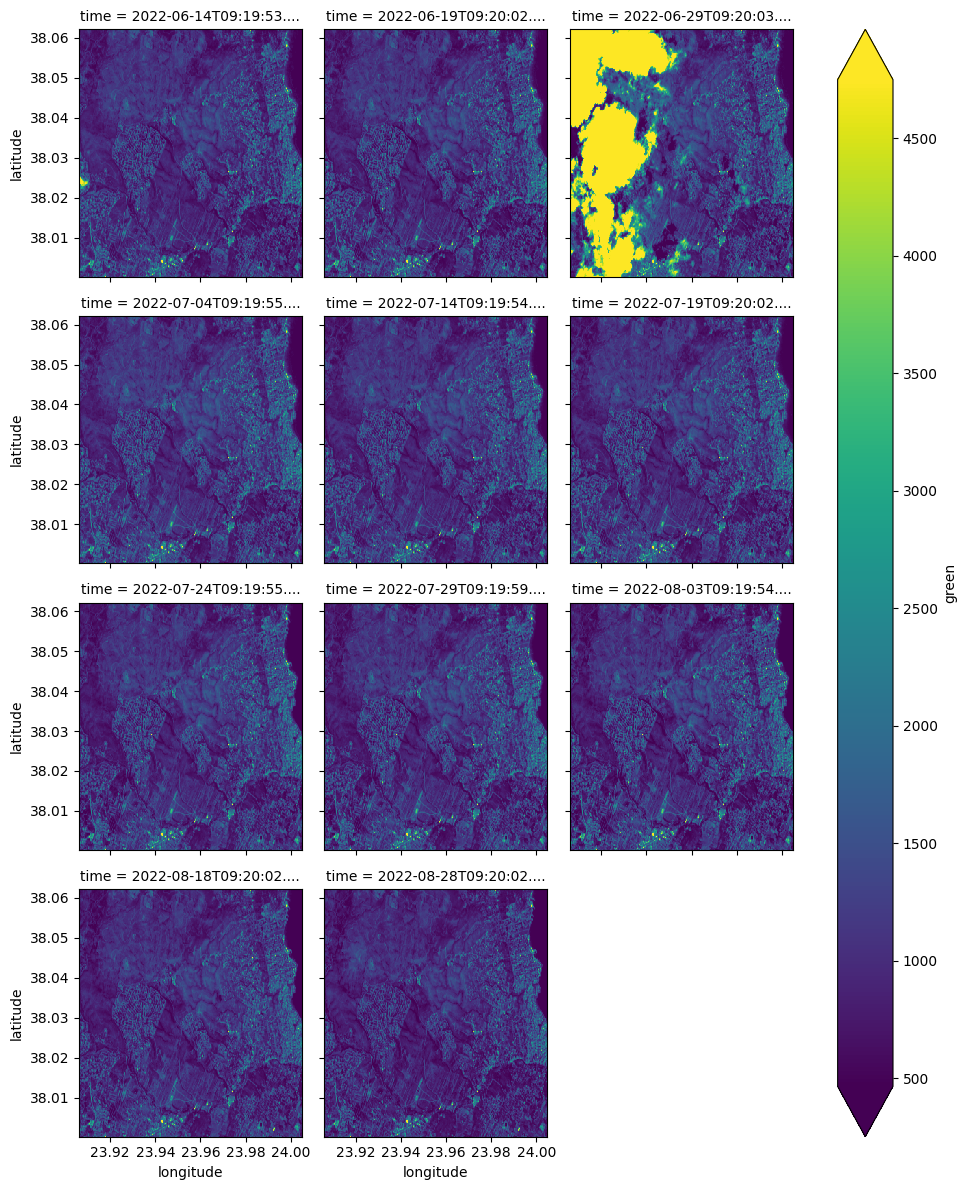

In [18]:
# data.B04.plot.imshow(col='time', col_wrap=3)
data.green.plot.imshow(col='time', col_wrap=3, robust=True)

### Plot a RGB composite

While xarray simplifies the plotting of single-band images, creating three-band color representations akin to photos is a more intricate task. Levels and values have to be normalized and be brighten by using the alpha channel. This procedure might not be straight forward for all images and locations. The following procedure is specifically designed to map three distinct data variables or measurements from a loaded dataset to the red, green, and blue channels required to generate a true-color image that mirrors how humans perceive landscapes.

For instance, providing measurements like red, green, and blue from a dataset will produce a true-color image, replicating the natural hues of the observed scene. Conversely, using measurements such as nir, red, and green, or any other combination of three satellite bands, will result in a false-color image. This capability not only enhances the visual appeal of the data but also facilitates clearer interpretation of spatial patterns and environmental changes within the datasets. Through leveraging these functionalities, researchers can effectively harness the power of xarray for more insightful analysis in fields ranging from environmental monitoring to geospatial research

In [ ]:
def rgb_composite(data):

    def brighten(band):
        alpha=0.13
        beta=0
        return np.clip(alpha*band+beta, 0,255)

    def normalize(band):
        band_min, band_max = (band.min(), band.max())
        return ((band-band_min)/((band_max - band_min)))

    red = data.red.isel(time=0)
    blue = data.blue.isel(time=0)
    green = data.green.isel(time=0)

    red_b=brighten(red)
    blue_b=brighten(blue)
    green_b=brighten(green)

    red_bn = normalize(red_b)
    green_bn = normalize(green_b)
    blue_bn = normalize(blue_b)

    rgb_composite_bn= np.dstack((red_bn, green_bn, blue_bn))
    plt.imshow(rgb_composite_bn)

And then just call it using the dataset we have already loaded

In [ ]:
rgb_composite(data)

### Animation of scenes

Creating an animation from plots offers a dynamic and engaging way to visualize temporal changes in data, such as satellite images. Animations provide a smooth and continuous representation, making it easier to observe trends, patterns, and anomalies over time that might be missed in static plots. This method enhances the viewer's ability to grasp the progression and evolution of data, offering a clearer and more intuitive understanding of complex temporal dynamics. Additionally, animations can make presentations more compelling and informative, capturing the audience's attention and effectively conveying the significance of temporal variations in the data.

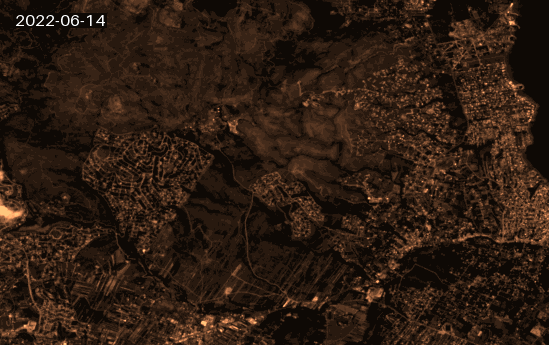

In [12]:
# dgif(arr=data.B03,cmap="copper",fps=5).compute()
dgif(arr=data.green,cmap="copper",fps=5).compute()